In [1]:
# update paths to your own
# TRAIN_DIR = r"/Users/chloe/Desktop/msba program/fall 2025/MIS 382N/ML Project/archive (1)/training"
# VAL_DIR   = r"/Users/chloe/Desktop/msba program/fall 2025/MIS 382N/ML Project/archive (1)/validation"
# TEST_DIR  = r"/Users/chloe/Desktop/msba program/fall 2025/MIS 382N/ML Project/archive (1)/evaluation"

In [76]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from xgboost import plot_importance

In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

num_classes = len(train_gen.class_indices)
print("Classes:", train_gen.class_indices)


Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.
Found 3347 images belonging to 11 classes.
Classes: {'Bread': 0, 'Dairy product': 1, 'Dessert': 2, 'Egg': 3, 'Fried food': 4, 'Meat': 5, 'Noodles-Pasta': 6, 'Rice': 7, 'Seafood': 8, 'Soup': 9, 'Vegetable-Fruit': 10}


## Transfer Learning via MobileNet2

In [4]:
# Load pretrained MobileNetV2
base_model = MobileNetV2(
    weights="imagenet", 
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

# Freeze base model layers (no training on them)
base_model.trainable = False

# Add custom classifier on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(
    optimizer=Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,588,747 (9.88 MB)

 Trainable params: 330,763 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [5]:
history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen
)

Epoch 1/10


/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


309/309 ━━━━━━━━━━━━━━━━━━━━ 70s 221ms/step - accuracy: 0.3948 - loss: 1.8364 - val_accuracy: 0.7466 - val_loss: 0.8159
Epoch 2/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 65s 211ms/step - accuracy: 0.7393 - loss: 0.7970 - val_accuracy: 0.7805 - val_loss: 0.6875
Epoch 3/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 67s 218ms/step - accuracy: 0.7824 - loss: 0.6548 - val_accuracy: 0.7988 - val_loss: 0.6247
Epoch 4/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 67s 218ms/step - accuracy: 0.8131 - loss: 0.5684 - val_accuracy: 0.8064 - val_loss: 0.5974
Epoch 5/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 67s 218ms/step - accuracy: 0.8218 - loss: 0.5264 - val_accuracy: 0.8187 - val_loss: 0.5764
Epoch 6/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 66s 212ms/step - accuracy: 0.8399 - loss: 0.4859 - val_accuracy: 0.8111 - val_loss: 0.5647
Epoch 7/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 71s 229ms/step - accuracy: 0.8542 - loss: 0.4463 - val_accuracy: 0.8242 - val_loss: 0.5468
Epoch 8/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 68s 221ms/step - accuracy: 0.8640 - loss: 0.4143 - val

In [6]:
# Unfreeze last 30 layers
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(1e-5),   # smaller learning rate for fine-tuning
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)

Epoch 1/5
309/309 ━━━━━━━━━━━━━━━━━━━━ 90s 281ms/step - accuracy: 0.6901 - loss: 0.9909 - val_accuracy: 0.8015 - val_loss: 0.6295
Epoch 2/5
309/309 ━━━━━━━━━━━━━━━━━━━━ 86s 280ms/step - accuracy: 0.8096 - loss: 0.5592 - val_accuracy: 0.8163 - val_loss: 0.5862
Epoch 3/5
309/309 ━━━━━━━━━━━━━━━━━━━━ 85s 276ms/step - accuracy: 0.8452 - loss: 0.4737 - val_accuracy: 0.8257 - val_loss: 0.5573
Epoch 4/5
309/309 ━━━━━━━━━━━━━━━━━━━━ 90s 290ms/step - accuracy: 0.8668 - loss: 0.4158 - val_accuracy: 0.8350 - val_loss: 0.5302
Epoch 5/5
309/309 ━━━━━━━━━━━━━━━━━━━━ 87s 282ms/step - accuracy: 0.8784 - loss: 0.3662 - val_accuracy: 0.8394 - val_loss: 0.5175


In [7]:
model.evaluate(test_gen)

105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 166ms/step - accuracy: 0.8066 - loss: 0.5818


[0.4465143084526062, 0.8565880060195923]

In [8]:
# # Create a folder for models if it doesn't exist
# os.makedirs("models", exist_ok=True)

# # Save the model in H5 format
# model.save("models/food_classifier.keras")

# print("Model saved at: models/food_classifier.keras")

Model saved at: models/food_classifier.keras


In [9]:
y_pred_probs = model.predict(test_gen)

# integer predictions (0,1,2,...)
pred_classes = np.argmax(y_pred_probs, axis=1)

# get list of class names, in the correct order
class_names = list(test_gen.class_indices.keys())

# convert integers → class names (the labels your USDA table expects)
pred_labels = [class_names[i] for i in pred_classes]

# confidence score
confidence_scores = np.max(y_pred_probs, axis=1)


105/105 ━━━━━━━━━━━━━━━━━━━━ 18s 170ms/step


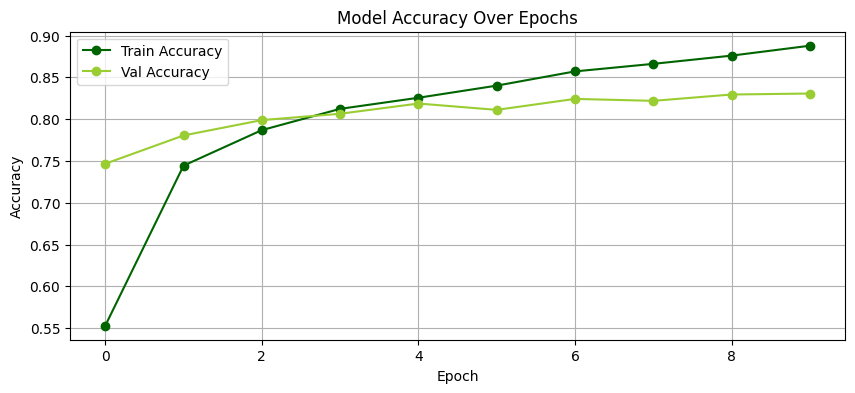

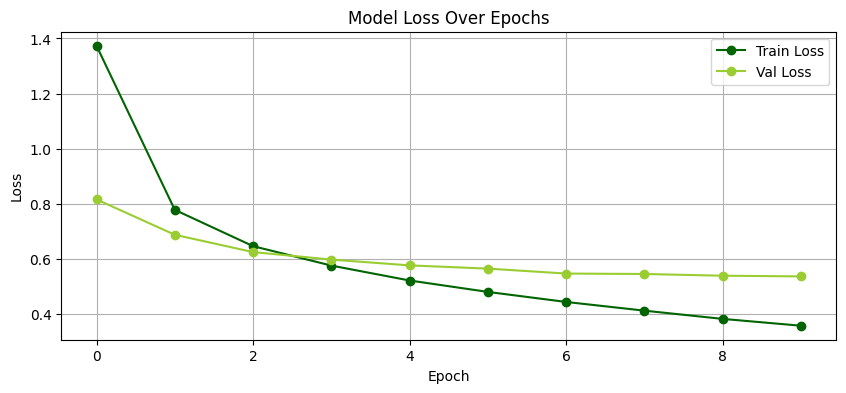

In [10]:
# --- Accuracy Curve ---
plt.figure(figsize=(10, 4))
plt.plot(history.history["accuracy"], label="Train Accuracy", marker="o", color='darkgreen')
plt.plot(history.history["val_accuracy"], label="Val Accuracy", marker="o", color='yellowgreen')
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# --- Loss Curve ---
plt.figure(figsize=(10, 4))
plt.plot(history.history["loss"], label="Train Loss", marker="o", color='darkgreen')
plt.plot(history.history["val_loss"], label="Val Loss", marker="o", color='yellowgreen')
plt.title("Model Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


105/105 ━━━━━━━━━━━━━━━━━━━━ 18s 175ms/step


<Figure size 1000x800 with 0 Axes>

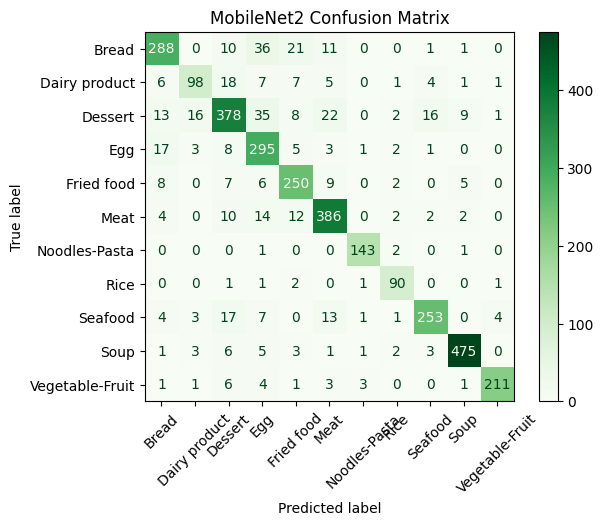

In [11]:
# Predict test labels
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = test_gen.classes

# Class names
class_names = list(test_gen.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Greens', xticks_rotation=45, values_format='d')
plt.title("MobileNet2 Confusion Matrix")
plt.show()


In [12]:
print(classification_report(y_true, y_pred, target_names=class_names))

                 precision    recall  f1-score   support

          Bread       0.84      0.78      0.81       368
  Dairy product       0.79      0.66      0.72       148
        Dessert       0.82      0.76      0.79       500
            Egg       0.72      0.88      0.79       335
     Fried food       0.81      0.87      0.84       287
           Meat       0.85      0.89      0.87       432
  Noodles-Pasta       0.95      0.97      0.96       147
           Rice       0.87      0.94      0.90        96
        Seafood       0.90      0.83      0.87       303
           Soup       0.96      0.95      0.95       500
Vegetable-Fruit       0.97      0.91      0.94       231

       accuracy                           0.86      3347
      macro avg       0.86      0.86      0.86      3347
   weighted avg       0.86      0.86      0.86      3347



## Transfer Learning via ResNet50 

In [13]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
).flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
).flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
).flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.
Found 3347 images belonging to 11 classes.


In [14]:
res_base = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

res_base.trainable = False

x = res_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.3)(x)
res_output = Dense(num_classes, activation="softmax")(x)

res_model = Model(inputs=res_base.input, outputs=res_output)

res_model.compile(
    optimizer=Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

res_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,642,443 (94.00 MB)

 Trainable params: 1,054,731 (4.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [15]:
res_history = res_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=8
)

Epoch 1/8


/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


309/309 ━━━━━━━━━━━━━━━━━━━━ 252s 811ms/step - accuracy: 0.5290 - loss: 1.4597 - val_accuracy: 0.8067 - val_loss: 0.5875
Epoch 2/8
309/309 ━━━━━━━━━━━━━━━━━━━━ 241s 779ms/step - accuracy: 0.8189 - loss: 0.5431 - val_accuracy: 0.8309 - val_loss: 0.4962
Epoch 3/8
309/309 ━━━━━━━━━━━━━━━━━━━━ 243s 788ms/step - accuracy: 0.8680 - loss: 0.4026 - val_accuracy: 0.8504 - val_loss: 0.4568
Epoch 4/8
309/309 ━━━━━━━━━━━━━━━━━━━━ 241s 779ms/step - accuracy: 0.8938 - loss: 0.3335 - val_accuracy: 0.8595 - val_loss: 0.4257
Epoch 5/8
309/309 ━━━━━━━━━━━━━━━━━━━━ 239s 775ms/step - accuracy: 0.9074 - loss: 0.2828 - val_accuracy: 0.8627 - val_loss: 0.4173
Epoch 6/8
309/309 ━━━━━━━━━━━━━━━━━━━━ 266s 863ms/step - accuracy: 0.9209 - loss: 0.2513 - val_accuracy: 0.8679 - val_loss: 0.4051
Epoch 7/8
309/309 ━━━━━━━━━━━━━━━━━━━━ 245s 793ms/step - accuracy: 0.9352 - loss: 0.2087 - val_accuracy: 0.8650 - val_loss: 0.4059
Epoch 8/8
309/309 ━━━━━━━━━━━━━━━━━━━━ 239s 774ms/step - accuracy: 0.9463 - loss: 0.1758 - va

In [16]:
for layer in res_base.layers[-30:]:
    layer.trainable = True

res_model.compile(
    optimizer=Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

res_history_fine = res_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)

Epoch 1/5
309/309 ━━━━━━━━━━━━━━━━━━━━ 330s 1s/step - accuracy: 0.8819 - loss: 0.3633 - val_accuracy: 0.8717 - val_loss: 0.3986
Epoch 2/5
309/309 ━━━━━━━━━━━━━━━━━━━━ 344s 1s/step - accuracy: 0.9582 - loss: 0.1577 - val_accuracy: 0.8746 - val_loss: 0.3836
Epoch 3/5
309/309 ━━━━━━━━━━━━━━━━━━━━ 339s 1s/step - accuracy: 0.9793 - loss: 0.1007 - val_accuracy: 0.8781 - val_loss: 0.3805
Epoch 4/5
309/309 ━━━━━━━━━━━━━━━━━━━━ 342s 1s/step - accuracy: 0.9881 - loss: 0.0670 - val_accuracy: 0.8773 - val_loss: 0.3759
Epoch 5/5
309/309 ━━━━━━━━━━━━━━━━━━━━ 337s 1s/step - accuracy: 0.9923 - loss: 0.0473 - val_accuracy: 0.8822 - val_loss: 0.3745


In [17]:
res_test_acc = res_model.evaluate(test_gen)
print("ResNet50 Test Accuracy:", res_test_acc)

105/105 ━━━━━━━━━━━━━━━━━━━━ 62s 588ms/step - accuracy: 0.8839 - loss: 0.3660 
ResNet50 Test Accuracy: [0.2820392847061157, 0.9091724157333374]


In [18]:
# res_model.save("models/resnet50_food_classifier.keras", include_optimizer=False)

# print("Model saved at: models/resnet50_food_classifier.keras")

Model saved at: models/resnet50_food_classifier.keras


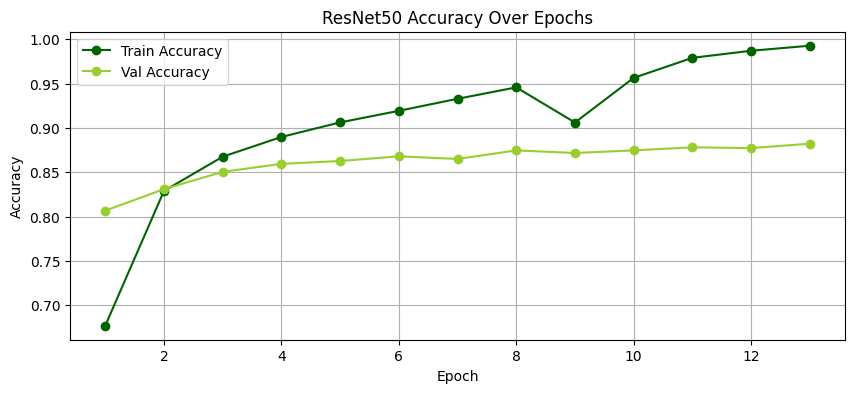

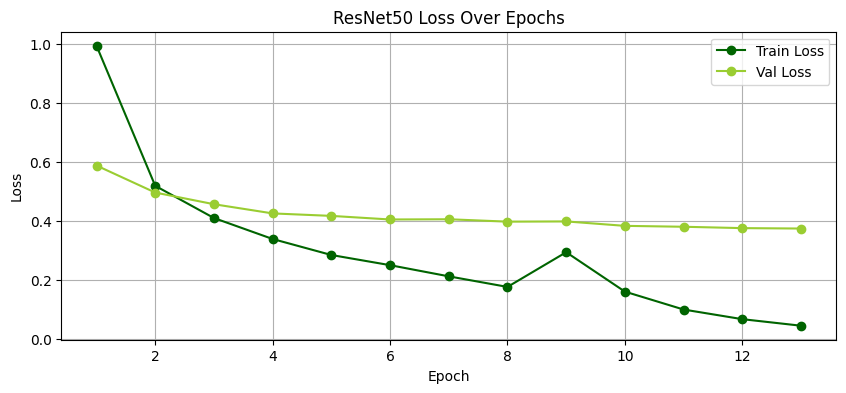

In [19]:
acc = res_history.history["accuracy"] + res_history_fine.history["accuracy"]
val_acc = res_history.history["val_accuracy"] + res_history_fine.history["val_accuracy"]

loss = res_history.history["loss"] + res_history_fine.history["loss"]
val_loss = res_history.history["val_loss"] + res_history_fine.history["val_loss"]

epochs = range(1, len(acc) + 1)

# accuracy curve
plt.figure(figsize=(10, 4))
plt.plot(epochs, acc, label="Train Accuracy", marker="o",color='darkgreen')
plt.plot(epochs, val_acc, label="Val Accuracy", marker="o", color='yellowgreen')
plt.title("ResNet50 Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

# loss curve
plt.figure(figsize=(10, 4))
plt.plot(epochs, loss, label="Train Loss", marker="o",color='darkgreen')
plt.plot(epochs, val_loss, label="Val Loss", marker="o",color='yellowgreen')
plt.title("ResNet50 Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

105/105 ━━━━━━━━━━━━━━━━━━━━ 68s 642ms/step 


<Figure size 1200x1000 with 0 Axes>

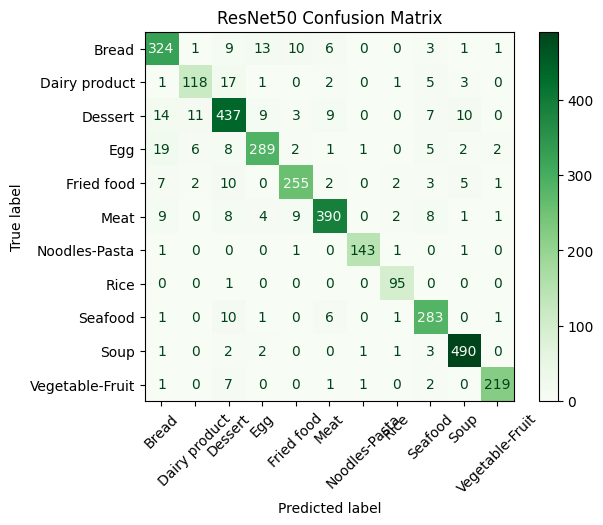

In [20]:
y_prob = res_model.predict(test_gen)
y_pred = np.argmax(y_prob, axis=1)

y_true = test_gen.classes

class_names = list(test_gen.class_indices.keys())
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Greens", xticks_rotation=45, values_format='d')
plt.title("ResNet50 Confusion Matrix")
plt.show()

In [21]:
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

                 precision    recall  f1-score   support

          Bread       0.86      0.88      0.87       368
  Dairy product       0.86      0.80      0.83       148
        Dessert       0.86      0.87      0.87       500
            Egg       0.91      0.86      0.88       335
     Fried food       0.91      0.89      0.90       287
           Meat       0.94      0.90      0.92       432
  Noodles-Pasta       0.98      0.97      0.98       147
           Rice       0.92      0.99      0.95        96
        Seafood       0.89      0.93      0.91       303
           Soup       0.96      0.98      0.97       500
Vegetable-Fruit       0.97      0.95      0.96       231

       accuracy                           0.91      3347
      macro avg       0.91      0.91      0.91      3347
   weighted avg       0.91      0.91      0.91      3347



## Nutritional Facts

In [145]:
# update path to fit your own 
MODEL_PATH   = "models/food_classifier.keras"
USDA_CSV     = "USDA.csv"
RECIPES_CSV  = "recipes.csv"

In [146]:
CLASS_NAMES = [
    "Bread",
    "Dairy product",
    "Dessert",
    "Egg",
    "Fried food",
    "Meat",
    "Noodles-Pasta",
    "Rice",
    "Seafood",
    "Soup",
    "Vegetable-Fruit",
]

IMG_SIZE = (224, 224)

In [147]:
print("Loading trained CNN model...")
cnn_model = load_model(MODEL_PATH)
print("CNN model loaded.")

Loading trained CNN model...
CNN model loaded.


In [148]:
def preprocess_image(img_path, target_size=IMG_SIZE):
    """
    Load and preprocess a single image file for the CNN.
    """
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    x = x / 255.0  # rescale, same as training generators
    x = np.expand_dims(x, axis=0)
    return x

def predict_image_class(img_path):
    """
    Returns (predicted_class_name, confidence, full_prob_vector)
    given a path to an image file.
    """
    x = preprocess_image(img_path)
    probs = cnn_model.predict(x, verbose=0)
    class_idx = int(np.argmax(probs, axis=1)[0])
    confidence = float(np.max(probs))
    class_name = CLASS_NAMES[class_idx]
    return class_name, confidence, probs[0]

In [149]:
# sanity check
test_image_path = "/Users/chloe/Desktop/msba program/fall 2025/MIS 382N/ML Project/spaghetti.jpg"
pred_class, conf, _ = predict_image_class(test_image_path)
print("Predicted:", pred_class, "Confidence:", conf)

Predicted: Noodles-Pasta Confidence: 0.8219528794288635


In [150]:
usda = pd.read_csv(USDA_CSV)
print("USDA shape:", usda.shape)
display(usda.head())

USDA shape: (7058, 16)


,ID,Description,Calories,Protein,TotalFat,Carbohydrate,Sodium,SaturatedFat,Cholesterol,Sugar,Calcium,Iron,Potassium,VitaminC,VitaminE,VitaminD
0,1001,"BUTTER,WITH SALT",717.0,0.85,81.11,0.06,714.0,51.368,215.0,0.06,24.0,0.02,24.0,0.0,2.32,1.5
1,1002,"BUTTER,WHIPPED,WITH SALT",717.0,0.85,81.11,0.06,827.0,50.489,219.0,0.06,24.0,0.16,26.0,0.0,2.32,1.5
2,1003,"BUTTER OIL,ANHYDROUS",876.0,0.28,99.48,0.00,2.0,61.924,256.0,0.00,4.0,0.00,5.0,0.0,2.80,1.8
3,1004,"CHEESE,BLUE",353.0,21.40,28.74,2.34,1395.0,18.669,75.0,0.50,528.0,0.31,256.0,0.0,0.25,0.5
4,1005,"CHEESE,BRICK",371.0,23.24,29.68,2.79,560.0,18.764,94.0,0.51,674.0,0.43,136.0,0.0,0.26,0.5


In [151]:
USDA_NUTRIENT_COLS = [
    "Calories",
    "Protein",
    "TotalFat",
    "Carbohydrate",
    "Sodium",
    "SaturatedFat",
    "Cholesterol",
    "Sugar",
]

# simple keyword-based mapping from USDA to CNN category
category_keywords = {
    "Bread": ["bread", "bagel", "bun", "roll", "tortilla", "pita"],
    "Dairy product": ["milk", "cheese", "yogurt", "cream", "butter"],
    "Dessert": ["cake", "cookie", "brownie", "pie", "ice cream", "pudding"],
    "Egg": ["egg"],
    "Fried food": ["fried", "tempura", "fritter", "nugget"],
    "Meat": ["beef", "pork", "lamb", "steak", "sausage", "bacon", "ham"],
    "Noodles-Pasta": ["pasta", "noodle", "spaghetti", "macaroni", "lasagna"],
    "Rice": ["rice", "risotto", "paella"],
    "Seafood": ["fish", "salmon", "shrimp", "tuna", "crab", "lobster"],
    "Soup": ["soup", "broth", "stew", "chowder"],
    "Vegetable-Fruit": ["vegetable", "fruit", "apple", "banana", "broccoli", "carrot"],
}

In [152]:
def map_usda_to_category(description: str):
    desc = str(description).lower()
    for cat, keywords in category_keywords.items():
        if any(k in desc for k in keywords):
            return cat
    return None

usda["cnn_category"] = usda["Description"].apply(map_usda_to_category)
print("\nUSDA mapped to categories (including NaN):")
display(usda["cnn_category"].value_counts(dropna=False))


USDA mapped to categories (including NaN):


cnn_category
None               3552
Meat               1499
Dairy product       528
Soup                358
Vegetable-Fruit     210
Dessert             196
Bread               194
Seafood             146
Noodles-Pasta       142
Fried food           88
Egg                  74
Rice                 71
Name: count, dtype: int64

In [153]:
# conditional mean nutrition from USDA
usda_category_nutrition = (
    usda.dropna(subset=USDA_NUTRIENT_COLS + ["cnn_category"])
        .groupby("cnn_category")[USDA_NUTRIENT_COLS]
        .mean()
        .round(2)
)
print("\nUSDA category-level average nutrition:")
display(usda_category_nutrition)


USDA category-level average nutrition:


,Calories,Protein,TotalFat,Carbohydrate,Sodium,SaturatedFat,Cholesterol,Sugar
cnn_category,,,,,,,,
Bread,296.41,10.08,8.31,45.97,493.60,1.91,10.29,7.45
Dairy product,256.88,8.95,15.40,21.68,321.85,7.35,26.15,13.28
Dessert,384.90,4.55,12.71,64.45,497.30,3.68,7.48,29.73
Egg,202.34,15.42,8.47,15.95,450.66,2.34,235.66,3.30
Fried food,238.26,21.48,12.24,9.94,349.67,3.46,85.43,1.06
Meat,214.51,22.13,12.79,1.87,322.62,4.78,79.61,0.61
Noodles-Pasta,118.74,4.26,2.59,19.54,441.61,0.72,5.06,3.39
Rice,211.39,4.60,3.79,39.53,243.50,0.73,1.72,2.47
Seafood,135.94,21.52,4.74,0.94,544.27,0.98,68.22,0.20


In [154]:
recipes_raw = pd.read_csv(RECIPES_CSV, index_col=0)
print("\nRecipes raw shape:", recipes_raw.shape)
display(recipes_raw.head())


Recipes raw shape: (1090, 14)


,recipe_name,prep_time,cook_time,total_time,servings,yield,ingredients,directions,rating,url,cuisine_path,nutrition,timing,img_src
0,Apple-Cranberry Crostada,NaN,NaN,NaN,8,6 to 8 - servings,"3 tablespoons butter, 2 pounds Granny Smith ap...",Heat butter in a large skillet over medium-hig...,4.4,https://www.allrecipes.com/recipe/76931/apple-...,/Desserts/Fruit Desserts/Apple Dessert Recipes/,"Total Fat 18g 23%, Saturated Fat 7g 34%, Chole...","Servings: 8, Yield: 6 to 8 - servings",https://www.allrecipes.com/thmb/Tf1wH73bfH6Oql...
1,Apple Pie by Grandma Ople,30 mins,1 hrs,1 hrs 30 mins,8,1 9-inch pie,"8 small Granny Smith apples, or as needed, ½ c...","Peel and core apples, then thinly slice. Set a...",4.8,https://www.allrecipes.com/recipe/12682/apple-...,/Desserts/Pies/Apple Pie Recipes/,"Total Fat 19g 24%, Saturated Fat 9g 46%, Chole...","Prep Time: 30 mins, Cook Time: 1 hrs, Total Ti...",https://www.allrecipes.com/thmb/1I95oiTGz6aEpu...
2,Sarah's Homemade Applesauce,10 mins,15 mins,25 mins,4,NaN,"4 apples - peeled, cored and chopped, ¾ cup w...","Combine apples, water, sugar, and cinnamon in ...",4.8,https://www.allrecipes.com/recipe/51301/sarahs...,/Side Dish/Applesauce Recipes/,"Total Fat 0g 0%, Sodium 3mg 0%, Total Carbohyd...","Prep Time: 10 mins, Cook Time: 15 mins, Total ...",https://www.allrecipes.com/thmb/VY5d0tZHB8xz6y...
3,Apple Crisp,30 mins,45 mins,1 hrs 15 mins,12,1 9x13-inch pan,"10 cups all-purpose apples, peeled, cored and ...",Preheat the oven to 350 degrees F (175 degrees...,4.7,https://www.allrecipes.com/recipe/12409/apple-...,/Desserts/Crisps and Crumbles Recipes/Apple Cr...,"Total Fat 8g 11%, Saturated Fat 5g 25%, Choles...","Prep Time: 30 mins, Cook Time: 45 mins, Total ...",https://www.allrecipes.com/thmb/uAzhPOh86PfR-N...
4,Apple Pie Filling,20 mins,20 mins,2 hrs 40 mins,40,5 9-inch pies,"18 cups thinly sliced apples, 3 tablespoons le...",Toss apples with lemon juice in a large bowl a...,4.7,https://www.allrecipes.com/recipe/12681/apple-...,/Desserts/Pies/Apple Pie Recipes/,"Total Fat 0g 0%, Sodium 61mg 3%, Total Carbohy...","Prep Time: 20 mins, Cook Time: 20 mins, Additi...",https://www.allrecipes.com/thmb/c0bbYaS1V_mTt_...


In [155]:
def parse_full_nutrition(nutrition_text):
    """
    Parses an AllRecipes-style nutrition string, extracting calories, fat, carbs,
    protein, sugar, sodium, cholesterol, and saturated fat.

    Example input:
    'Total Fat 19g 24%, Saturated Fat 9g 46%, Cholesterol 55mg 18%, 
     Sodium 250mg 11%, Carbs 42g 15%, Protein 4g 8%, Calories: 393'

    Returns a Series with numeric nutritional values.
    """

    fields = {
        "Calories": np.nan,
        "TotalFat": np.nan,
        "SaturatedFat": np.nan,
        "Cholesterol": np.nan,
        "Sodium": np.nan,
        "Carbohydrate": np.nan,
        "Sugar": np.nan,
        "Protein": np.nan,
    }

    if pd.isna(nutrition_text):
        return pd.Series(fields)

    text = str(nutrition_text)

    patterns = {
        "Calories":       r"Calories[: ]+(\d+)",
        "TotalFat":       r"Total Fat (\d+)g",
        "SaturatedFat":   r"Saturated Fat (\d+)g",
        "Cholesterol":    r"Cholesterol (\d+)mg",
        "Sodium":         r"Sodium (\d+)mg",
        "Carbohydrate":   r"Carbs (\d+)g|Carbohydrate (\d+)g",
        "Sugar":          r"Sugar (\d+)g",
        "Protein":        r"Protein (\d+)g",
    }

    for field, pat in patterns.items():
        match = re.search(pat, text)
        if match:
            # Some patterns capture two groups (Carbs OR Carbohydrate)
            val = [g for g in match.groups() if g is not None][0]
            fields[field] = float(val)

    return pd.Series(fields)


recipes = recipes_raw.copy()

parsed = recipes["nutrition"].apply(parse_full_nutrition)
recipes = pd.concat([recipes, parsed], axis=1)

print("Parsed recipe nutrition:")
recipes

Parsed recipe nutrition:


,recipe_name,prep_time,cook_time,total_time,servings,yield,ingredients,directions,rating,url,...,timing,img_src,Calories,TotalFat,SaturatedFat,Cholesterol,Sodium,Carbohydrate,Sugar,Protein
0,Apple-Cranberry Crostada,NaN,NaN,NaN,8,6 to 8 - servings,"3 tablespoons butter, 2 pounds Granny Smith ap...",Heat butter in a large skillet over medium-hig...,4.4,https://www.allrecipes.com/recipe/76931/apple-...,...,"Servings: 8, Yield: 6 to 8 - servings",https://www.allrecipes.com/thmb/Tf1wH73bfH6Oql...,NaN,18.0,7.0,19.0,128.0,60.0,NaN,4.0
1,Apple Pie by Grandma Ople,30 mins,1 hrs,1 hrs 30 mins,8,1 9-inch pie,"8 small Granny Smith apples, or as needed, ½ c...","Peel and core apples, then thinly slice. Set a...",4.8,https://www.allrecipes.com/recipe/12682/apple-...,...,"Prep Time: 30 mins, Cook Time: 1 hrs, Total Ti...",https://www.allrecipes.com/thmb/1I95oiTGz6aEpu...,NaN,19.0,9.0,31.0,124.0,52.0,NaN,2.0
2,Sarah's Homemade Applesauce,10 mins,15 mins,25 mins,4,NaN,"4 apples - peeled, cored and chopped, ¾ cup w...","Combine apples, water, sugar, and cinnamon in ...",4.8,https://www.allrecipes.com/recipe/51301/sarahs...,...,"Prep Time: 10 mins, Cook Time: 15 mins, Total ...",https://www.allrecipes.com/thmb/VY5d0tZHB8xz6y...,NaN,0.0,NaN,NaN,3.0,32.0,NaN,0.0
3,Apple Crisp,30 mins,45 mins,1 hrs 15 mins,12,1 9x13-inch pan,"10 cups all-purpose apples, peeled, cored and ...",Preheat the oven to 350 degrees F (175 degrees...,4.7,https://www.allrecipes.com/recipe/12409/apple-...,...,"Prep Time: 30 mins, Cook Time: 45 mins, Total ...",https://www.allrecipes.com/thmb/uAzhPOh86PfR-N...,NaN,8.0,5.0,20.0,98.0,61.0,NaN,2.0
4,Apple Pie Filling,20 mins,20 mins,2 hrs 40 mins,40,5 9-inch pies,"18 cups thinly sliced apples, 3 tablespoons le...",Toss apples with lemon juice in a large bowl a...,4.7,https://www.allrecipes.com/recipe/12681/apple-...,...,"Prep Time: 20 mins, Cook Time: 20 mins, Additi...",https://www.allrecipes.com/thmb/c0bbYaS1V_mTt_...,NaN,0.0,NaN,NaN,61.0,33.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1085,Date-Nut Balls,15 mins,10 mins,30 mins,48,4 dozen balls,"14 tablespoons butter, 1 cup pitted chopped da...",Melt butter in a saucepan over medium heat; co...,3.8,https://www.allrecipes.com/recipe/240653/date-...,...,"Prep Time: 15 mins, Cook Time: 10 mins, Additi...",https://www.allrecipes.com/thmb/LXm_15zLymhZ7c...,NaN,5.0,2.0,9.0,33.0,8.0,NaN,0.0
1086,Jamaica Cake,NaN,NaN,NaN,14,1 - 13x9 inch pan,"2 cups white sugar, 1 ½ cups vegetable oil, 1 ...","Mix together sugar, vegetable oil, pecans, flo...",4.6,https://www.allrecipes.com/recipe/7509/jamaica...,...,"Servings: 14, Yield: 1 - 13x9 inch pan",https://www.allrecipes.com/thmb/tI7g5xY5-qPV5v...,NaN,33.0,4.0,40.0,272.0,61.0,NaN,6.0
1087,Best Hot Sauce,10 mins,20 mins,30 mins,100,2 cups,"10 fresh hot chile peppers, stems removed, 1 ...","Place peppers, onion, dates, basil, parsley, t...",4.9,https://www.allrecipes.com/recipe/242153/best-...,...,"Prep Time: 10 mins, Cook Time: 20 mins, Total ...",https://www.allrecipes.com/thmb/80wUYzFvbycfxx...,NaN,1.0,0.0,NaN,29.0,1.0,NaN,0.0
1088,Moist Date Nut Bread,15 mins,50 mins,1 hrs 35 mins,12,1 9x5-inch loaf,"2 ½ cups chopped dates, ¼ cup butter, 1 cup bo...",Preheat the oven to 350 degrees F (175 degrees...,4.5,https://www.allrecipes.com/recipe/51446/moist-...,...,"Prep Time: 15 mins, Cook Time: 50 mins, Additi...",https://www.allrecipes.com/thmb/bYsnompJZ6UAF9...,NaN,10.0,3.0,26.0,365.0,47.0,NaN,4.0


In [156]:
nutr_cols = [
    "Calories", "TotalFat", "SaturatedFat", "Cholesterol",
    "Sodium", "Carbohydrate", "Sugar", "Protein"
]

In [157]:
def infer_category(ingredients):
    if pd.isna(ingredients):
        return "other"
    
    text = ingredients.lower()

    if any(x in text for x in ["fried", "deep fry", "breaded"]):
        return "fried"
    if any(x in text for x in ["pasta", "noodle", "spaghetti", "macaroni"]):
        return "pasta"
    if any(x in text for x in ["soup", "broth", "stew"]):
        return "soup"
    if any(x in text for x in ["cake", "cookie", "brownie", "sugar", "chocolate"]):
        return "dessert"
    if any(x in text for x in ["apple", "fruit"]):
        return "fruit"
    
    return "other"

recipes["recipe_category"] = recipes["ingredients"].apply(infer_category)

In [158]:
category_means = recipes.groupby("recipe_category")[nutr_cols].mean()
category_means

,Calories,TotalFat,SaturatedFat,Cholesterol,Sodium,Carbohydrate,Sugar,Protein
recipe_category,,,,,,,,
dessert,NaN,12.660112,6.230894,45.720000,212.974290,42.752355,NaN,4.807692
fried,NaN,30.333333,13.333333,91.666667,864.000000,29.000000,NaN,28.000000
fruit,NaN,7.137931,3.122449,38.583333,223.327586,36.672414,NaN,8.689655
other,NaN,15.901235,5.279476,61.433962,315.267206,25.592742,NaN,11.317073
pasta,NaN,17.500000,8.750000,51.375000,650.750000,90.875000,NaN,16.000000
soup,NaN,16.400000,6.566667,68.571429,733.566667,30.033333,NaN,19.100000


In [159]:
def fill_missing(row):
    cat = row["recipe_category"]
    
    for col in nutr_cols:
        if pd.isna(row[col]):
            row[col] = category_means.loc[cat, col]
    return row

recipes = recipes.apply(fill_missing, axis=1)

In [160]:
recipes[nutr_cols] = recipes[nutr_cols].fillna(recipes[nutr_cols].mean())

In [161]:
recipes

,recipe_name,prep_time,cook_time,total_time,servings,yield,ingredients,directions,rating,url,...,img_src,Calories,TotalFat,SaturatedFat,Cholesterol,Sodium,Carbohydrate,Sugar,Protein,recipe_category
0,Apple-Cranberry Crostada,NaN,NaN,NaN,8,6 to 8 - servings,"3 tablespoons butter, 2 pounds Granny Smith ap...",Heat butter in a large skillet over medium-hig...,4.4,https://www.allrecipes.com/recipe/76931/apple-...,...,https://www.allrecipes.com/thmb/Tf1wH73bfH6Oql...,NaN,18.0,7.000000,19.000000,128.0,60.0,NaN,4.0,dessert
1,Apple Pie by Grandma Ople,30 mins,1 hrs,1 hrs 30 mins,8,1 9-inch pie,"8 small Granny Smith apples, or as needed, ½ c...","Peel and core apples, then thinly slice. Set a...",4.8,https://www.allrecipes.com/recipe/12682/apple-...,...,https://www.allrecipes.com/thmb/1I95oiTGz6aEpu...,NaN,19.0,9.000000,31.000000,124.0,52.0,NaN,2.0,dessert
2,Sarah's Homemade Applesauce,10 mins,15 mins,25 mins,4,NaN,"4 apples - peeled, cored and chopped, ¾ cup w...","Combine apples, water, sugar, and cinnamon in ...",4.8,https://www.allrecipes.com/recipe/51301/sarahs...,...,https://www.allrecipes.com/thmb/VY5d0tZHB8xz6y...,NaN,0.0,6.230894,45.720000,3.0,32.0,NaN,0.0,dessert
3,Apple Crisp,30 mins,45 mins,1 hrs 15 mins,12,1 9x13-inch pan,"10 cups all-purpose apples, peeled, cored and ...",Preheat the oven to 350 degrees F (175 degrees...,4.7,https://www.allrecipes.com/recipe/12409/apple-...,...,https://www.allrecipes.com/thmb/uAzhPOh86PfR-N...,NaN,8.0,5.000000,20.000000,98.0,61.0,NaN,2.0,dessert
4,Apple Pie Filling,20 mins,20 mins,2 hrs 40 mins,40,5 9-inch pies,"18 cups thinly sliced apples, 3 tablespoons le...",Toss apples with lemon juice in a large bowl a...,4.7,https://www.allrecipes.com/recipe/12681/apple-...,...,https://www.allrecipes.com/thmb/c0bbYaS1V_mTt_...,NaN,0.0,6.230894,45.720000,61.0,33.0,NaN,0.0,dessert
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1085,Date-Nut Balls,15 mins,10 mins,30 mins,48,4 dozen balls,"14 tablespoons butter, 1 cup pitted chopped da...",Melt butter in a saucepan over medium heat; co...,3.8,https://www.allrecipes.com/recipe/240653/date-...,...,https://www.allrecipes.com/thmb/LXm_15zLymhZ7c...,NaN,5.0,2.000000,9.000000,33.0,8.0,NaN,0.0,dessert
1086,Jamaica Cake,NaN,NaN,NaN,14,1 - 13x9 inch pan,"2 cups white sugar, 1 ½ cups vegetable oil, 1 ...","Mix together sugar, vegetable oil, pecans, flo...",4.6,https://www.allrecipes.com/recipe/7509/jamaica...,...,https://www.allrecipes.com/thmb/tI7g5xY5-qPV5v...,NaN,33.0,4.000000,40.000000,272.0,61.0,NaN,6.0,dessert
1087,Best Hot Sauce,10 mins,20 mins,30 mins,100,2 cups,"10 fresh hot chile peppers, stems removed, 1 ...","Place peppers, onion, dates, basil, parsley, t...",4.9,https://www.allrecipes.com/recipe/242153/best-...,...,https://www.allrecipes.com/thmb/80wUYzFvbycfxx...,NaN,1.0,0.000000,61.433962,29.0,1.0,NaN,0.0,other
1088,Moist Date Nut Bread,15 mins,50 mins,1 hrs 35 mins,12,1 9x5-inch loaf,"2 ½ cups chopped dates, ¼ cup butter, 1 cup bo...",Preheat the oven to 350 degrees F (175 degrees...,4.5,https://www.allrecipes.com/recipe/51446/moist-...,...,https://www.allrecipes.com/thmb/bYsnompJZ6UAF9...,NaN,10.0,3.000000,26.000000,365.0,47.0,NaN,4.0,dessert


In [162]:
def compute_calories(row):
    if pd.notna(row["Calories"]):
        return row["Calories"]
    
    # Only compute if macros exist
    if (
        pd.notna(row["TotalFat"]) and 
        pd.notna(row["Carbohydrate"]) and
        pd.notna(row["Protein"])
    ):
        return (
            9 * row["TotalFat"] +
            4 * row["Carbohydrate"] +
            4 * row["Protein"]
        )
    
    return np.nan

recipes["Calories"] = recipes.apply(compute_calories, axis=1)
recipes

,recipe_name,prep_time,cook_time,total_time,servings,yield,ingredients,directions,rating,url,...,img_src,Calories,TotalFat,SaturatedFat,Cholesterol,Sodium,Carbohydrate,Sugar,Protein,recipe_category
0,Apple-Cranberry Crostada,NaN,NaN,NaN,8,6 to 8 - servings,"3 tablespoons butter, 2 pounds Granny Smith ap...",Heat butter in a large skillet over medium-hig...,4.4,https://www.allrecipes.com/recipe/76931/apple-...,...,https://www.allrecipes.com/thmb/Tf1wH73bfH6Oql...,418.0,18.0,7.000000,19.000000,128.0,60.0,NaN,4.0,dessert
1,Apple Pie by Grandma Ople,30 mins,1 hrs,1 hrs 30 mins,8,1 9-inch pie,"8 small Granny Smith apples, or as needed, ½ c...","Peel and core apples, then thinly slice. Set a...",4.8,https://www.allrecipes.com/recipe/12682/apple-...,...,https://www.allrecipes.com/thmb/1I95oiTGz6aEpu...,387.0,19.0,9.000000,31.000000,124.0,52.0,NaN,2.0,dessert
2,Sarah's Homemade Applesauce,10 mins,15 mins,25 mins,4,NaN,"4 apples - peeled, cored and chopped, ¾ cup w...","Combine apples, water, sugar, and cinnamon in ...",4.8,https://www.allrecipes.com/recipe/51301/sarahs...,...,https://www.allrecipes.com/thmb/VY5d0tZHB8xz6y...,128.0,0.0,6.230894,45.720000,3.0,32.0,NaN,0.0,dessert
3,Apple Crisp,30 mins,45 mins,1 hrs 15 mins,12,1 9x13-inch pan,"10 cups all-purpose apples, peeled, cored and ...",Preheat the oven to 350 degrees F (175 degrees...,4.7,https://www.allrecipes.com/recipe/12409/apple-...,...,https://www.allrecipes.com/thmb/uAzhPOh86PfR-N...,324.0,8.0,5.000000,20.000000,98.0,61.0,NaN,2.0,dessert
4,Apple Pie Filling,20 mins,20 mins,2 hrs 40 mins,40,5 9-inch pies,"18 cups thinly sliced apples, 3 tablespoons le...",Toss apples with lemon juice in a large bowl a...,4.7,https://www.allrecipes.com/recipe/12681/apple-...,...,https://www.allrecipes.com/thmb/c0bbYaS1V_mTt_...,132.0,0.0,6.230894,45.720000,61.0,33.0,NaN,0.0,dessert
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1085,Date-Nut Balls,15 mins,10 mins,30 mins,48,4 dozen balls,"14 tablespoons butter, 1 cup pitted chopped da...",Melt butter in a saucepan over medium heat; co...,3.8,https://www.allrecipes.com/recipe/240653/date-...,...,https://www.allrecipes.com/thmb/LXm_15zLymhZ7c...,77.0,5.0,2.000000,9.000000,33.0,8.0,NaN,0.0,dessert
1086,Jamaica Cake,NaN,NaN,NaN,14,1 - 13x9 inch pan,"2 cups white sugar, 1 ½ cups vegetable oil, 1 ...","Mix together sugar, vegetable oil, pecans, flo...",4.6,https://www.allrecipes.com/recipe/7509/jamaica...,...,https://www.allrecipes.com/thmb/tI7g5xY5-qPV5v...,565.0,33.0,4.000000,40.000000,272.0,61.0,NaN,6.0,dessert
1087,Best Hot Sauce,10 mins,20 mins,30 mins,100,2 cups,"10 fresh hot chile peppers, stems removed, 1 ...","Place peppers, onion, dates, basil, parsley, t...",4.9,https://www.allrecipes.com/recipe/242153/best-...,...,https://www.allrecipes.com/thmb/80wUYzFvbycfxx...,13.0,1.0,0.000000,61.433962,29.0,1.0,NaN,0.0,other
1088,Moist Date Nut Bread,15 mins,50 mins,1 hrs 35 mins,12,1 9x5-inch loaf,"2 ½ cups chopped dates, ¼ cup butter, 1 cup bo...",Preheat the oven to 350 degrees F (175 degrees...,4.5,https://www.allrecipes.com/recipe/51446/moist-...,...,https://www.allrecipes.com/thmb/bYsnompJZ6UAF9...,294.0,10.0,3.000000,26.000000,365.0,47.0,NaN,4.0,dessert


In [163]:
def map_recipe_to_category(row):
    """
    Map recipe to the same category space as the CNN using text:
    combine recipe_name + ingredients + cuisine_path.
    """
    text = " ".join([
        str(row.get("recipe_name", "")),
        str(row.get("ingredients", "")),
        str(row.get("cuisine_path", "")),
    ]).lower()
    
    for cat, keywords in category_keywords.items():
        if any(k in text for k in keywords):
            return cat
    return None

recipes["cnn_category"] = recipes.apply(map_recipe_to_category, axis=1)
print("\nRecipes mapped to categories:")
display(recipes["cnn_category"].value_counts(dropna=False))


Recipes mapped to categories:


cnn_category
Dairy product      501
Bread              183
None               126
Vegetable-Fruit    108
Dessert             77
Meat                43
Egg                 17
Seafood             15
Soup                12
Rice                 6
Noodles-Pasta        1
Fried food           1
Name: count, dtype: int64

In [164]:
def train_healthiness_model(target_nutrient):
    """
    Train an ML model to predict the nutrient the user cares about.
    Automatically removes the target variable from the feature list.
    """
    print(f"\nTraining Healthiness Model for nutrient: {target_nutrient}")

    if target_nutrient not in nutr_cols:
        raise ValueError(f"{target_nutrient} is not a valid nutrient name.")

    base_features = [
        "Calories", "TotalFat", "SaturatedFat", "Sodium",
        "Carbohydrate", "Sugar", "Protein", "Cholesterol"
    ]

    # remove target var
    feature_cols = [f for f in base_features if f != target_nutrient]

    # X = features, y = nutrient to predict
    X = recipes[feature_cols]
    y = recipes[target_nutrient]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # XGBoost model
    model = XGBRegressor(
        n_estimators=250,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8
    )

    model.fit(X_train, y_train)

    # Evaluation
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print("XGBoost Healthiness Model Performance")
    print("RMSE:", rmse)
    print("R² Score:", r2)

    # Add predicted scores to recipe table
    raw_preds = model.predict(recipes[feature_cols])

    recipes["healthiness_raw"] = raw_preds
    recipes["healthiness_score"] = scale_healthiness_to_100(raw_preds)

    return model


In [165]:
def scale_healthiness_to_100(raw_scores):
    """
    Convert raw nutrient predictions into a 0–100 healthiness score.
    Lower nutrient = higher health score.
    """
    min_val = raw_scores.min()
    max_val = raw_scores.max()

    if max_val == min_val:
        return np.full_like(raw_scores, 100)

    scaled = 100 * (1 - (raw_scores - min_val) / (max_val - min_val))
    return scaled

In [166]:
def recommend_by_healthiness(category, top_n=5):
    """
    Recommend the healthiest recipes (lowest predicted nutrient score)
    within the chosen CNN category.
    """
    df = recipes[recipes["cnn_category"] == category].copy()
    if df.empty:
        print(f"No recipes found for category: {category}")
        return df
    
    df = df.sort_values("healthiness_score", ascending=True)
    return df[["recipe_name", "ingredients", "healthiness_score"]].head(top_n)

In [167]:
def recommend_healthier_in_same_category(
    category: str,
    nutrient: str = "Calories",
    top_n: int = 5,
):
    
    df = recipes.copy()
    df = df[df["cnn_category"] == category]
    df = df.dropna(subset=[nutrient])
    
    if df.empty:
        print(f"No recipes found for category '{category}'.")
        return df
    
    df = df.sort_values(by=nutrient, ascending=True)
    cols_to_show = ["recipe_name", "ingredients", nutrient]
    return df[cols_to_show].head(top_n)


def recommend_healthier_in_same_category(
    category: str,
    nutrient: str = "Calories",
    top_n: int = 5
):
    df = recipes.copy()
    df = df[df["cnn_category"] == category]
    df = df.dropna(subset=[nutrient])
    
    if df.empty:
        print(f"No recipes found for category '{category}'.")
        return df
    
    df = df.sort_values(by=nutrient, ascending=True)
    cols_to_show = ["recipe_name", "ingredients", nutrient]
    return df[cols_to_show].head(top_n)


In [168]:
def analyze_uploaded_food_image(
    img_path: str,
    craving_nutrient: str = "Calories",   # we can also use "Cholesterol" etc.
    top_n_same: int = 5,
    top_n_other_cat: int = 3,
):
    """
    End-to-end:
      1. Takes an uploaded image path,
      2. Uses the CNN to predict class label,
      4. Suggests lower-nutrient recipes in same category,
      5. Suggests healthier alternative categories based on USDA.
    """
    print("Analyzing uploaded image...")
    pred_class, conf, _ = predict_image_class(img_path)
    print(f"\nCNN predicts this image is: **{pred_class}** (confidence {conf:.1%})")
    
    health_model = train_healthiness_model(craving_nutrient)
    
    print(f"\nHealthiest options *within* '{pred_class}' (lowest predicted {craving_nutrient}):")
    same_cat_recs = recommend_by_healthiness(pred_class, top_n_same)
    display(same_cat_recs)


    # Healthier alternative categories
    print(f"\nHealthier alternative categories (based on USDA mean {craving_nutrient}):")
    
    # Ensure nutrient exists
    if craving_nutrient not in usda_category_nutrition.columns:
        raise ValueError(f"Nutrient '{craving_nutrient}' not found in USDA data.")
    
    # Sort by the nutrient the user cares about
    healthy_categories = (
        usda_category_nutrition
            .sort_values(craving_nutrient)    # ← NOW DYNAMIC
            .reset_index()
            .rename(columns={"cnn_category": "category"})
    )
    
    # Remove predicted class
    healthy_categories = healthy_categories[
        healthy_categories["category"] != pred_class
    ]
    
    # Select top N categories
    other_cat_recs = healthy_categories.head(top_n_other_cat)
    
    display(other_cat_recs)


    
    return pred_class, same_cat_recs, other_cat_recs


In [173]:
# update path to fit your own
example_image = "/Users/chloe/Desktop/msba program/fall 2025/MIS 382N/ML Project/chicken.jpg"
pred_class, same_cat_rec, other_cat_rec = analyze_uploaded_food_image(
    example_image,
    craving_nutrient="Calories", 
    top_n_same=5,
    top_n_other_cat=3,
)

Analyzing uploaded image...

CNN predicts this image is: **Fried food** (confidence 67.6%)

Training Healthiness Model for nutrient: Calories
XGBoost Healthiness Model Performance
RMSE: 28.753216357193324
R² Score: 0.9788620324860545

Healthiest options *within* 'Fried food' (lowest predicted Calories):


,recipe_name,ingredients,healthiness_score
876,Honey Apricot Pork Chops,"4 boneless pork chops, Kosher salt and fres...",95.314751



Healthier alternative categories (based on USDA mean Calories):


,category,Calories,Protein,TotalFat,Carbohydrate,Sodium,SaturatedFat,Cholesterol,Sugar
0,Soup,69.25,3.35,2.14,9.19,749.18,0.67,6.10,2.45
1,Noodles-Pasta,118.74,4.26,2.59,19.54,441.61,0.72,5.06,3.39
2,Seafood,135.94,21.52,4.74,0.94,544.27,0.98,68.22,0.20


In [ ]:
# recipes.to_csv(
#     "full_recipes_with_nutrition_and_cnn_class.csv",
#     index=False
# )